# Contextualizing the Problem


Given two images of linear equations, as below:


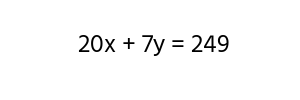
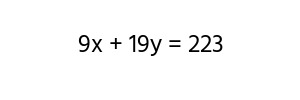


We must construct a model that solves the system and gives us:





# Strategy to Solve the Problem

The most difficult part of the problem is getting the matrix's and vector's system. For exemple:

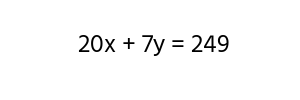
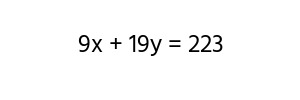

We can rewrite as:

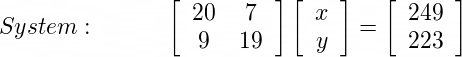

To get these numbers to solve the system, we'll excute two strategies to parser the figure.

Given the exemple image:

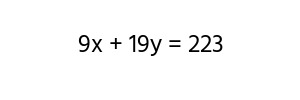

1. First, we'll get the "groups" of the image, that is, for this image, we'll get a cropped image with the x's group (**'9x'** in the image), the signal group (**'+'** in the image), the y's group (**'19y'** in the image), the equal group (**'='** in the image) and the constant group (**'223'** in the image, but it could include a the signal of the number like '-233', if it was '-233' instead '233').

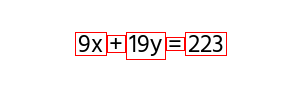

2. With this groups, we'll parser every group's image to get the "elements" in every group. **For exemple, for the x's group ('9x' in the image), we'll get an image for '9' and one for 'x'**:

    2.1 For the cropped image of the x's group:

      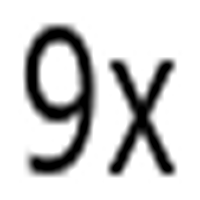
      
    2.2 We'll get the two images:
    
      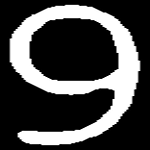
      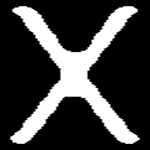
      
      
After the image parsing, we can train a model o identify the element's images (we'll utilize a Random Forest, because it's simple problem. But, if the equations were manuscript, we could utilize a Convolutional Neural Network to handle with the complexity):

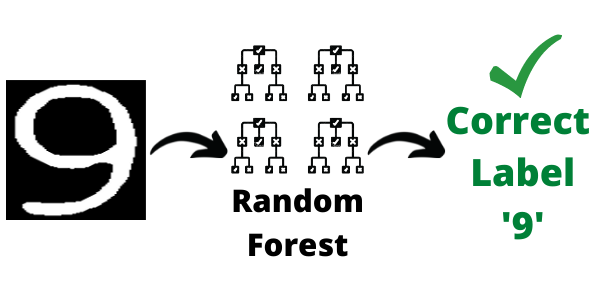

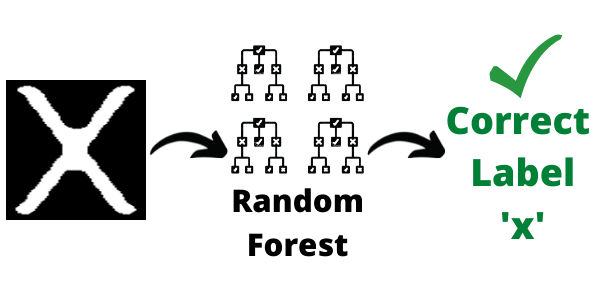

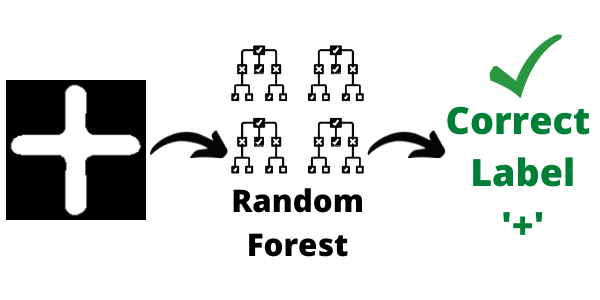


And convert the **original equation image** into a **string** with the model:

 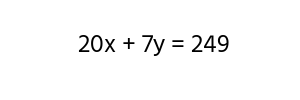
 
Converting:

<h1><center><b>'20x+7y=249'</b></center></h1>
  

After converting the image into string (**making an Optical Character Recognition - OCR**), we can parser the string with **Regular Expressions** and finally get the system in the matrix form, which can be solved with the numerical numpy solver to linear systems.


# Importing libraries

To solve this problem, we'll use:

* re - to manipulate regular expression
* numpy - to manipulate array and numeric linear system solver
* pandas - to manipulate tabular data
* cv2 - to manipulate images
* seaborn - to create graphs
* matplotlib - to visualize images
* sklearn - to create and train our model/to analyze the performance metrics of our model
* imblearn - to deal with imbalanced datasets

In [1]:
import re
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import solve
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Let's set the random seed:

In [2]:
np.random.seed(2022)

# Open the data

## Images

Let's create a function to find the image's path:

In [3]:
def get_image_path(folder_path,image_number):

    number_of_zeros_in_front_of_i = 5 - len(str(image_number))

    image_path = folder_path+'IMG_'+number_of_zeros_in_front_of_i*'0' + str(image_number) +'.png'

    return image_path
  

Let's verify if it's correct:

In [4]:
folder_path = '../input/linear-equation-images/equation1/'

image_path = get_image_path(folder_path,0)
image_path

'../input/linear-equation-images/equation1/IMG_00000.png'

Let's see the image:

In [5]:
def plot_image(image,cmap):
    plt.axis('off')
    plt.imshow(image, cmap=cmap, vmin=0, vmax=255)
    plt.show()

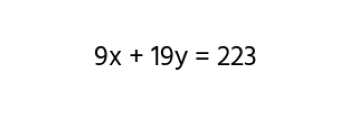

In [6]:
image = cv2.imread(image_path)
plot_image(image,'jet')

## Tabular Data

Let's open the tabular data:

In [7]:
data = pd.read_csv('../input/linear-equation-images/Equation_db.csv')
data

,File Name,Equation 1,Equation 2,Value of X,Value of Y
0,IMG_00587,7x + 2y = 56,18x + 14y = 206,6,7
1,IMG_09895,7x - 7y = 70,8x + 5y = 145,15,5
2,IMG_02064,12x + 19y = 88,2x + 9y = 38,1,4
3,IMG_11200,15x - 2y = 4,3x + 3y = 45,2,13
4,IMG_07880,6x + 5y = -11,8x + 10y = -38,4,-7
...,...,...,...,...,...
11995,IMG_02247,9x + y = 46,6x + 15y = 45,5,1
11996,IMG_07147,3x + 8y = -41,5x + 8y = -31,5,-7
11997,IMG_01548,8x + 6y = 40,6x + 18y = 84,2,4
11998,IMG_01396,13x + 14y = 201,16x + 11y = 210,9,6


Let's divide the data in train, validation and test:

In [8]:
def split_dataset(data,y_name,train_ratio=0.7,valid_ratio=0.15):
    X_train,X_valid,X_test=np.split(data.sample(frac=1, random_state=42),  [int(train_ratio*len(data)), int((valid_ratio+train_ratio)*len(data))])

    y_train=X_train[y_name]
    y_valid=X_valid[y_name]
    y_test=X_test[y_name]

    y_train.index=X_train.index
    y_valid.index=X_valid.index
    y_test.index=X_test.index

    X_train.drop(labels=y_name,axis=1,inplace=True)
    X_valid.drop(labels=y_name,axis=1,inplace=True)
    X_test.drop(labels=y_name,axis=1,inplace=True)

    return X_train,X_valid,X_test,y_train,y_valid,y_test

Once all the figures are made with computers caracters with the same font (easier training) and once one image contains multiple elements (one image of the dataset generates multiple samples to the model train) , we'll separate the dataset on train, validation and test on the proportion train_ratio = 0.3, valid_ratio=0.2 and test_ratio=0.5. With this, we really can verify the accuracy of the modelation on 50% of the data:

In [9]:
X_train,X_valid,X_test,y_train,y_valid,y_test = split_dataset(data,['Value of X','Value of Y'],train_ratio=0.3,valid_ratio=0.2)

Let's see the training dataset:

In [10]:
X_train

,File Name,Equation 1,Equation 2
1935,IMG_11728,11x - 10y = 18,14x + 8y = 168
6494,IMG_03820,6x + 8y = 124,9x + 13y = 194
1720,IMG_08437,3x + 5y = -22,4x + 19y = -128
9120,IMG_07055,15x + 12y = 57,16x + 13y = 59
360,IMG_10782,6x - 8y = -10,18x + 16y = 170
...,...,...,...
9136,IMG_10626,14x - 16y = 68,11x + 15y = 274
9169,IMG_00592,5x + 14y = 48,x + 12y = 28
9419,IMG_06940,3x + 18y = -81,14x + 7y = 161
3817,IMG_01070,18x + 7y = 85,17x + 5y = 69


And the correct answers to them:

In [11]:
y_train

,Value of X,Value of Y
1935,8,7
6494,10,8
1720,6,-8
9120,11,-9
360,5,5
...,...,...
9136,14,8
9169,4,2
9419,15,-7
3817,2,7


# Image Processing

## Getting the Groups


As said anteriorly, we'll get the groups in the image:

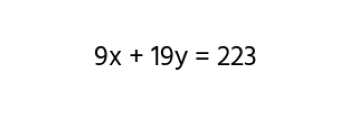

In [12]:
image = cv2.imread(image_path)
plot_image(image,'jet')

Let's convert the image to gray scale and, after, invert the scale:

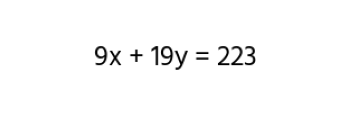

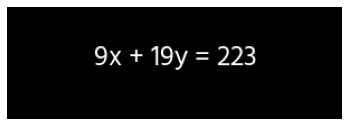

In [13]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_image(gray_image,'gray')


inverse_gray_image = cv2.bitwise_not(gray_image)
plot_image(inverse_gray_image,'gray')

Let's dilate the image:

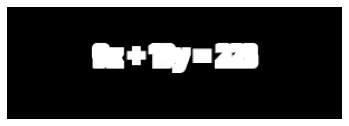

In [14]:
kernel = np.ones((3,3), np.uint8)
dilatate_image = cv2.dilate(inverse_gray_image, kernel, iterations=3)
plot_image(dilatate_image,'gray')

Now, we'll identify the groups in the image using the *findContours* from *OpenCV*:

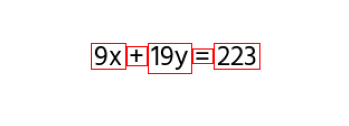

In [15]:
copied_image = image.copy()

# Convert to RGB
copied_image = cv2.cvtColor(copied_image, cv2.COLOR_BGR2RGB)

groups={}

cnts = cv2.findContours(dilatate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Lets sort the elements by the x postition,
# that is, the groups near to the left size
# we'll be processed first. This is important
# to guarantee the order of the equation.

cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)

    cropped_group = gray_image[y:y+h, x:x+w]
    groups[x] = cropped_group
    cv2.rectangle(copied_image, (x, y), (x+w, y+h), (255, 0, 0), 1)

plot_image(copied_image,'jet')

With this method, we succeed got the groups!!

## Get Elements inside the Groups

Let's use the same strategy above (*findContours*) to get the elements inside the groups. But first, let's pre-processing the group's image:

Group's Image:


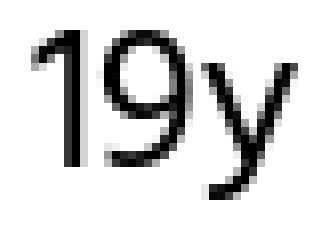

In [16]:
print("Group's Image:")
group = list(groups.values())[2]
plot_image(group,'gray')

To get a more clear image, we can resize it:

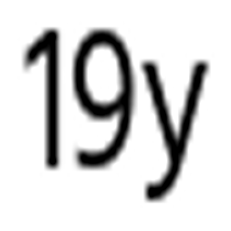

In [17]:
resized_group = cv2.resize(group, (200,200), interpolation = cv2.INTER_CUBIC)
plot_image(resized_group,'gray')

We can do better if we apply a binary filter:

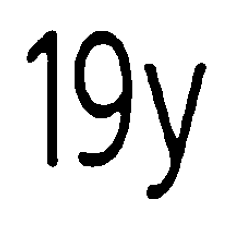

In [18]:
_,binary_resized_group = cv2.threshold(resized_group, 100, 255, cv2.THRESH_BINARY)
plot_image(binary_resized_group,'gray')

Machine Learning Vision Model's, generally, learn more and fast when dealing with sparse images. Let's invert the image:

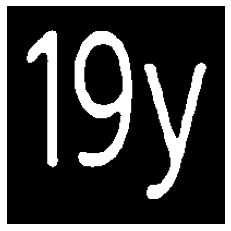

In [19]:
inverted_binary_resized_group = cv2.bitwise_not(binary_resized_group)
plot_image(inverted_binary_resized_group,'gray')

That's better. Now, to get a good division of the image, we'll apply an **erode** process on the image. With this, the elements will be more distant from each other and it'll be easier to separate them:

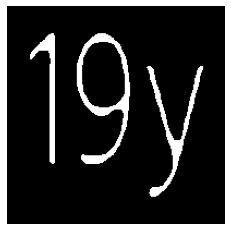

In [20]:
eroded_inverted_binary_resized_group = cv2.erode(inverted_binary_resized_group, kernel, iterations=2)
plot_image(eroded_inverted_binary_resized_group,'gray')

Now, let's apply the *findContours* function on this image:

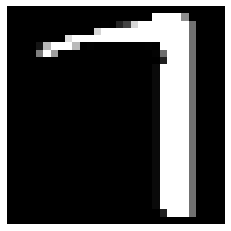

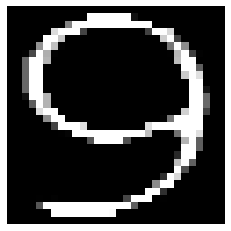

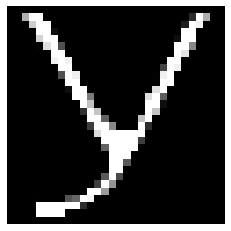

In [21]:
cnts = cv2.findContours(eroded_inverted_binary_resized_group, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Lets sort the elements by the x postition,
# that is, the groups near to the left size
# we'll be processed first. This is important
# to guarantee the order of the equation.
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

for c in cnts:

    if cv2.contourArea(c)>200:

        x, y, w, h = cv2.boundingRect(c)
        cropped_element = eroded_inverted_binary_resized_group[y-5:y+h+5, x-5:x+w+5]
        cropped_element = cv2.resize(cropped_element, (30,30), interpolation = cv2.INTER_CUBIC)
        plot_image(cropped_element,'gray')

We finally managed to separate the elements!!

Let's unite all this code one function that recives the equation image and return the element's images:

In [22]:
def get_elements_in_image(equation_image):
    
    # Convert image to gray
    gray_image = cv2.cvtColor(equation_image, cv2.COLOR_BGR2GRAY)
    
    # Invert the image
    inversed_gray_image = cv2.bitwise_not(gray_image)

    # Dilate the image
    kernel = np.ones((3,3), np.uint8)
    dilatate_image = cv2.dilate(inversed_gray_image, kernel, iterations=3)
    
    # Dict to save the groups images
    groups={}

    # Searching the groups
    cnts = cv2.findContours(dilatate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Lets sort the elements by the x postition,
    # that is, the groups near to the left size
    # we'll be processed first. This is important
    # to guarantee the order of the equation.

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)

        cropped_group = gray_image[y:y+h, x:x+w]
        groups[x] = cropped_group
        
    # Initializing the elements list
    elements = []

    # Searching elements inside each group
    for group in groups.values():
        
        # Resizing the image group
        resized_group = cv2.resize(group, (200,200), interpolation = cv2.INTER_CUBIC)
        
        # Applying the binary filter
        _,binary_resized_group = cv2.threshold(resized_group, 100, 255, cv2.THRESH_BINARY)
        
        # Inverting the colors of the image
        inverted_binary_resized_group = cv2.bitwise_not(binary_resized_group)
        
        # Applying erode function on image
        eroded_inverted_binary_resized_group = cv2.erode(inverted_binary_resized_group, kernel, iterations=2)
        
        cnts = cv2.findContours(eroded_inverted_binary_resized_group, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Lets sort the elements by the x postition,
        # that is, the groups near to the left size
        # we'll be processed first. This is important
        # to guarantee the order of the equation.
        
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

        for c in cnts:

            # To avoid that bad crops on the groups creates
            # inexisting elements
            if cv2.contourArea(c)>100:

                x, y, w, h = cv2.boundingRect(c)
                cropped_element = eroded_inverted_binary_resized_group[y-5:y+h+5, x-5:x+w+5]
                
                # Resizing the the cropped_image
                cropped_element = cv2.resize(cropped_element, (30,30), interpolation = cv2.INTER_CUBIC)
                
                elements.append(cropped_element)
      
    return elements

Let's see if it's working:

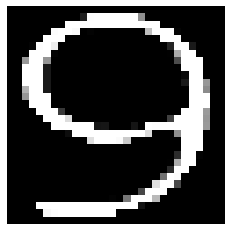

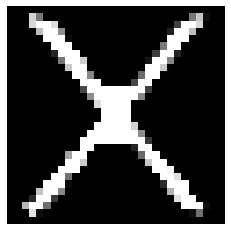

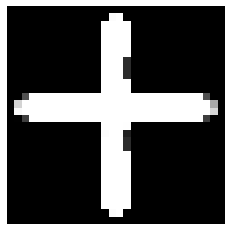

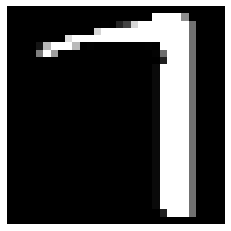

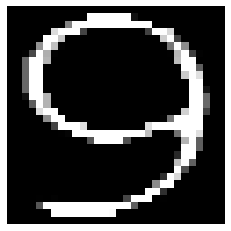

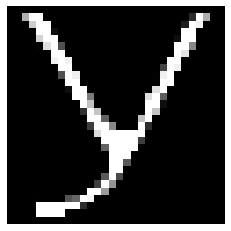

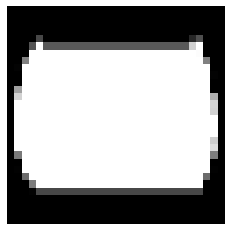

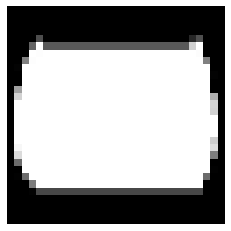

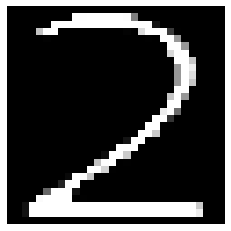

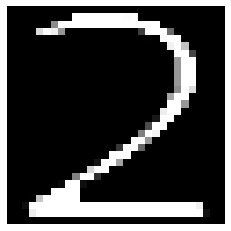

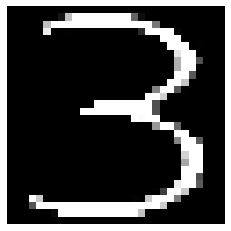

In [23]:
equation_image = cv2.imread(image_path)
elements = get_elements_in_image(equation_image)

for element in elements:
    plot_image(element,'gray')

We successfully parsed the image. However, it is worth realizing that, once the '=' signal is discontinuous, it was separated as two symbols '-'. This is not a problem. When we create the final string, we just need to add a new step to interpret '-','-' as '='.

# Creating the dataset with elements to train the model

Let's select randomly equations images and also randomly which digits or/and symbols of these images will be on the dataset:

In [24]:
# Initializing the new dataset
X_elements_images_train = []
y_elements_labels_train = []

# Folder Path
folder_path = '../input/linear-equation-images/equation1/'

for index in X_train.index:
    
    # To randomize the creation of the dataset, every equation image will have
    # 70% of probability to be selected to have elements (digits or symbols)
    # on the dataset.
    
    index_probability = np.random.uniform(0,1)
    
    if index_probability < 0.7:
    
        # Getting the image number
        image_number = int(X_train.loc[index]['File Name'][4:])

        # Acessing images X_train['Equation 1']
        image_path = get_image_path(folder_path,image_number)

        # Getting the Image
        equation_image = cv2.imread(image_path)

        # Get Images of the Elements
        image_elements = get_elements_in_image(equation_image)

        # Getting the elements labels by X_train['Equation 1']
        string_elements=list(re.sub(' ','',X_train.loc[index]['Equation 1']))
        equal_index=string_elements.index('=')
        string_elements[equal_index:equal_index+1]='-','-'

        # Creating the dataset
        for label_element,image_element in zip(string_elements,image_elements):
            
            # To randomize the creation of the dataset, every element (digits or symbols)
            # will have 80% of probability to be selected to be on the dataset.
            
            element_probability = np.random.uniform(0,1)
            
            if element_probability < 0.8:

                # Converting a imagem 30x30 do element em um vetor de dim 900
                image_element_vector = np.concatenate(image_element, axis=0)

                # Normalizing the vector
                image_element_vector = image_element_vector/255

                # Adding the image into the X_elements_images_train
                # and the correspondent label in y_elements_train

                X_elements_images_train.append(image_element_vector)
                y_elements_labels_train.append(label_element)

Let's converting the datasets lists into DataFrames:

In [25]:
X_elements_images_train = pd.DataFrame(X_elements_images_train)
y_elements_labels_train = pd.DataFrame(y_elements_labels_train,columns=['Label'])

Let's see the images DataFrame:

In [26]:
X_elements_images_train

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And the labels:

In [27]:
y_elements_labels_train

,Label
0,1
1,1
2,x
3,-
4,1
...,...
21693,6
21694,-
21695,2
21696,0


Let's take one random sample:

Label: 7


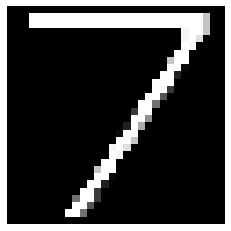

In [28]:
random_int = np.random.randint(0,X_elements_images_train.shape[0])

random_image_vector = X_elements_images_train.iloc[random_int].to_numpy()
random_image = 255*np.resize(random_image_vector,(30,30))

random_label = y_elements_labels_train.iloc[random_int]['Label']

print('Label:',str(random_label))
plot_image(random_image,'gray')


Now that we saw that the dataset was correctly implementated, let's see if it is balanced:

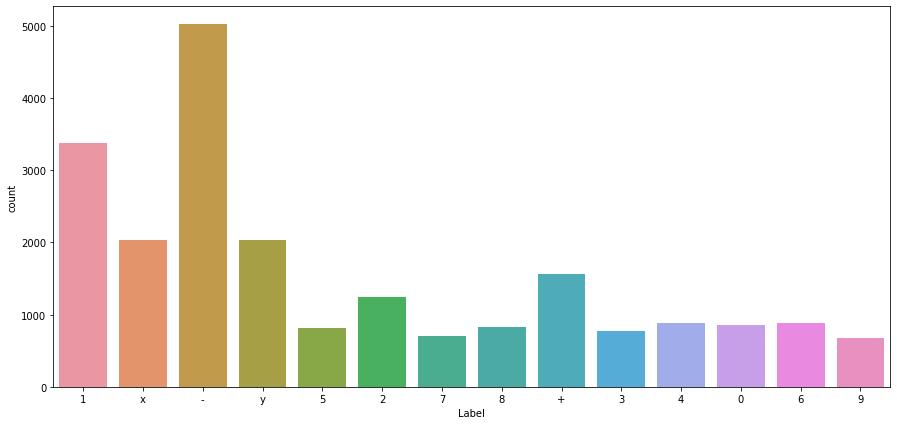

In [29]:
plt.figure(figsize=(15,7))
sns.countplot(x=y_elements_labels_train['Label'])
plt.show()

We see that this dataset is very imbalanced, which can difficult the models's learning. Let's use **Random Under-Sampling** to turn it balanced:

In [30]:
rus = RandomUnderSampler(random_state=20)
X_elements_images_train_resample, y_elements_labels_train_resample = rus.fit_resample(X_elements_images_train, y_elements_labels_train)

Let's see the balanced dataset:

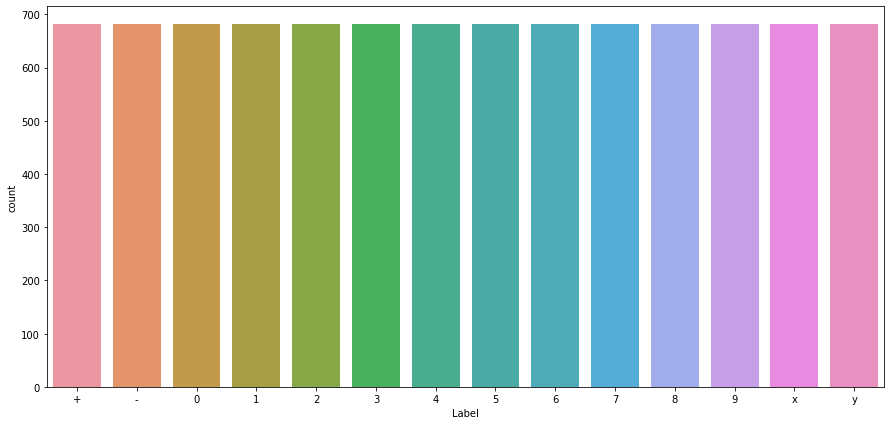

In [31]:
plt.figure(figsize=(15,7))
sns.countplot(x=y_elements_labels_train_resample['Label'])
plt.show()

Now, we can create also a validated dataset to see how the models performance in new data:

In [32]:
# Initializing the new dataset
X_elements_images_valid = []
y_elements_labels_valid = []

# Folder Path
folder_path = '../input/linear-equation-images/equation1/'

# Once each equation image have, in mean, 10 elements (symbols) take 
# 1500 equation images will gerate a dataset with ~20000 samples

for index in X_valid.index:
    
    # Getting the image number
    image_number = int(X_valid.loc[index]['File Name'][4:])
    
    # Acessing images X_train['Equation 1']
    image_path = get_image_path(folder_path,image_number)
    
    # Getting the Image
    equation_image = cv2.imread(image_path)

    # Get Images of the Elements
    image_elements = get_elements_in_image(equation_image)

    # Getting the elements labels by X_train['Equation 1']
    string_elements=list(re.sub(' ','',X_valid.loc[index]['Equation 1']))
    equal_index=string_elements.index('=')
    string_elements[equal_index:equal_index+1]='-','-'

    # Creating the dataset
    for label_element,image_element in zip(string_elements,image_elements):
        
        # Converting a imagem 30x30 do element em um vetor de dim 900
        image_element_vector = np.concatenate(image_element, axis=0)
        
        # Normalizing the vector
        image_element_vector = image_element_vector/255
        
        # Adding the image into the X_elements_images_train
        # and the correspondent label in y_elements_train
        
        X_elements_images_valid.append(image_element_vector)
        y_elements_labels_valid.append(label_element)

Converting the to DataFrames:

In [33]:
X_elements_images_valid = pd.DataFrame(X_elements_images_valid)
y_elements_labels_valid = pd.DataFrame(y_elements_labels_valid,columns=['Label'])

In [34]:
X_elements_images_valid

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With the datasets created, we can now train the model.

# Training the Model

Once the digits and symbols are in the same font and size, the task to predict them is not so hard. To do so, let's use a Random Forest:

In [35]:
model = RandomForestClassifier(max_depth=6,random_state=0,n_estimators=100)
model.fit(X_elements_images_train, y_elements_labels_train['Label'])

RandomForestClassifier(max_depth=6, random_state=0)

# Verifying Model's Metrics

Let's see the accuracy on the Train Data:

In [36]:
print('Accuracy on Train-Dataset:',model.score(X_elements_images_train, y_elements_labels_train['Label']))

Accuracy on Train-Dataset: 1.0


Pretty good!! To verify that the model isn't overfitted, let's validate on different and unseen data:

In [37]:
print('Accuracy on Validation-Dataset:',model.score(X_elements_images_valid, y_elements_labels_valid['Label']))

Accuracy on Validation-Dataset: 1.0


Wow!! The model really learn how to differenciate de images of the symbols and digits!! Let's see the **Confusion Matrix**:

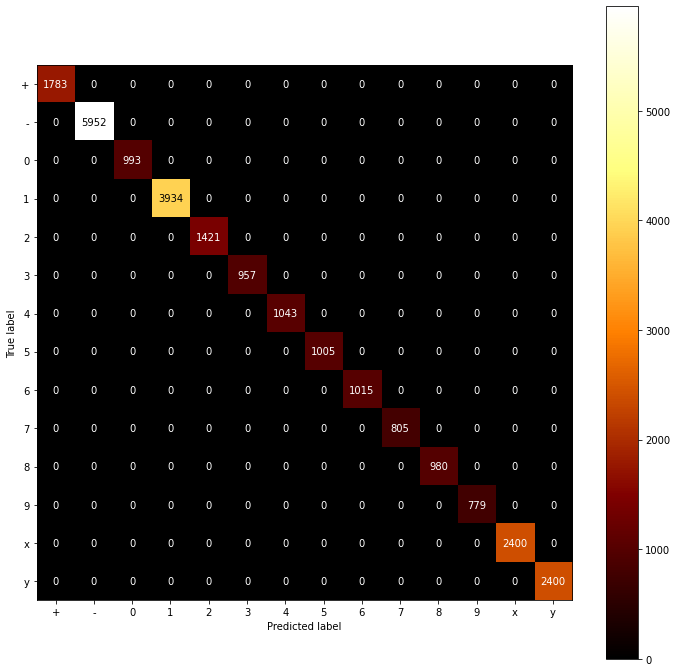

In [38]:
# Getting model's predictions
y_elements_pred_valid = model.predict(X_elements_images_valid)

# compute the confusion matrix
cm = confusion_matrix(y_elements_labels_valid['Label'].to_numpy(), y_elements_pred_valid,labels=model.classes_) 


cm = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(12,12))
cm.plot(ax=ax,cmap='afmhot')
plt.show()


We can see the model could correctly classify 100% of the unseen data from validation for every possible class. Once again, the digits and symbols are in the same font and size, which makes the task easier.

# Converting Image to String

With the model, let's create an function that converts the **equation's image** to **string**:

In [39]:
def transform_equation_image_to_string(equation_image):
    
    # Get Images of the Elements (Digits and Symbols like '+','-')
    image_elements = get_elements_in_image(equation_image)
    
    # Initializing the string
    equation_string = ''
    
    for image_element in image_elements:
        
        # Converting a imagem 30x30 do element em um vetor de dim 900
        image_element_vector = np.concatenate(image_element, axis=0)
        
        # Normalizing the vector
        image_element_vector = image_element_vector/255
        
        # The model will predict every 
        equation_string += model.predict(image_element_vector.reshape(1, -1))
        
    # Like we said, we must trade the '-','-' by '='
    equation_string = re.sub('--','=',equation_string[0])
        
    return equation_string
    

Let's test:

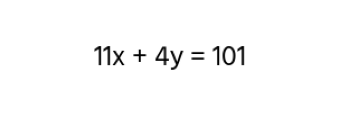

In [40]:
random_int = np.random.randint(0,X_train.shape[0])
random_image_number = int(X_train.iloc[random_int]['File Name'][4:])

random_image = cv2.imread(get_image_path(folder_path,random_image_number))

plot_image(random_image,'jet')

And the string is:

In [41]:
transform_equation_image_to_string(random_image)

'11x+4y=101'

It's working!!

# Getting the System Matrix and Vector from String

A simple function with Regular Expressions can do the job:

In [42]:
def solve_the_linear_system_with_strings(first_equation_string,second_equation_string,tol=1e-2):
    
    '''
    
     Let's create an system pattern:
     
     [a b] [x]   [e]  => first_equation_string
     [c d] [y]   [f]  => second_equation_string
     
     with the matrix A:
     
             [a b]
             [c d]
             
    And vector B:
    
             [e]
             [f]
     
    '''
    

    # Using Regular Expression to get the numbers in the string
    a,b,e = re.findall('([-+\d]+)?x([-+\d]+)y=([-+\d]+)',first_equation_string)[0]
    c,d,f = re.findall('([-+\d]+)?x([-+\d]+)y=([-+\d]+)',second_equation_string)[0]
    
    # in the case of 2x-y=3=> a=2,   **b=-1**  ,e=3
    converter_dict = {'-':-1,'+':1,'':1}
    
    A = [[a,b],
         [c,d]]
    
    B = [e,f]
    
    # Tranforming char into int, for exemple, '1' -> 1
    for i in range(2):
        
        B[i]=int(B[i])
        
        for j in range(2):
            try:
                A[i][j]=int(A[i][j])
            except:
                A[i][j] = converter_dict[A[i][j]]
                
                
    if np.abs(A[0][0]*A[1][1]-A[1][0]*A[0][1])<tol:
        
        # Singular matrix
        
        return 'NaN','NaN'
                
                
    A = np.array(A)
    B = np.array(B)
    
    x,y = solve(A,B)
    
    # Once all the output are integer, let's round the output to avoid
    # numerical errors
    
    return round(x),round(y)
    

In [43]:
x,y = solve_the_linear_system_with_strings('9x+19y=223','20x+7y=249')

print(f'Output:\tx={x} and y={y}')

Output:	x=10 and y=7


# Creating the Final Pipeline

Let's creating an function that, receving the two system images, solves the system:

In [44]:
def solve_linear_system_with_images(first_equation_image,second_equation_image):
    
    first_equation_string = transform_equation_image_to_string(first_equation_image)
    second_equation_string = transform_equation_image_to_string(second_equation_image)
    x,y = solve_the_linear_system_with_strings(first_equation_string,second_equation_string)
    return x,y

# Final Test (last 50% of the Dataset)

In [45]:
# Initializing the storage lists
x_pred = []
y_pred = []

# Folder Path
first_folder_path = '../input/linear-equation-images/equation1/'
second_folder_path = '../input/linear-equation-images/equation2/'

# System with Singular Matrix (Solution can't be found)
singular_matrix_index = []
valid_matrix_index = []

for index in X_test.index[:200]:
    
    # Getting the Image Number
    image_number = int(data.loc[index]['File Name'][4:])
    
    # Getting System Images Equations
    first_equation_image = cv2.imread(get_image_path(first_folder_path,image_number))
    second_equation_image = cv2.imread(get_image_path(second_folder_path,image_number))
    
    # Solving the System
    x,y = solve_linear_system_with_images(first_equation_image,second_equation_image)
    
    if x=='NaN' or y=='NaN':
        # Indetermining Linear System (Singular Matrix)
        singular_matrix_index.append(index)
    else:
        # Storing the values
        x_pred.append(x)
        y_pred.append(y)
        valid_matrix_index.append(index)

In [46]:
x_pred

[5,
 13,
 4,
 7,
 14,
 2,
 4,
 9,
 4,
 6,
 3,
 10,
 8,
 7,
 14,
 6,
 9,
 8,
 2,
 3,
 3,
 8,
 6,
 11,
 3,
 5,
 10,
 4,
 1,
 12,
 3,
 5,
 8,
 6,
 10,
 9,
 6,
 13,
 4,
 8,
 6,
 5,
 10,
 8,
 13,
 2,
 9,
 11,
 8,
 8,
 1,
 13,
 10,
 2,
 6,
 7,
 5,
 3,
 13,
 8,
 7,
 9,
 12,
 9,
 5,
 5,
 10,
 4,
 10,
 7,
 2,
 2,
 7,
 8,
 8,
 9,
 5,
 15,
 12,
 9,
 3,
 9,
 9,
 8,
 14,
 6,
 9,
 8,
 9,
 9,
 5,
 9,
 3,
 2,
 4,
 6,
 12,
 15,
 2,
 2,
 4,
 8,
 8,
 3,
 10,
 7,
 10,
 3,
 5,
 11,
 6,
 8,
 9,
 7,
 13,
 1,
 10,
 10,
 1,
 1,
 11,
 5,
 3,
 10,
 5,
 12,
 5,
 4,
 2,
 6,
 5,
 12,
 1,
 10,
 9,
 8,
 13,
 5,
 15,
 2,
 10,
 2,
 9,
 2,
 5,
 8,
 4,
 6,
 4,
 4,
 13,
 2,
 1,
 9,
 6,
 11,
 7,
 8,
 5,
 2,
 5,
 4,
 6,
 4,
 14,
 8,
 8,
 2,
 3,
 1,
 7,
 1,
 1,
 1,
 2,
 10,
 4,
 12,
 15,
 12,
 11,
 6,
 7,
 8,
 9,
 3,
 14,
 3,
 3,
 11,
 8,
 2,
 9,
 14,
 7,
 9,
 10,
 7,
 15]

In [47]:
from sklearn.metrics import r2_score

In [48]:
r2_score(y_test.loc[valid_matrix_index]['Value of Y'],y_pred)

0.9856685650416692

In [49]:
v=np.where(y_test.loc[valid_matrix_index]['Value of Y']!=y_pred,1,0)
for i in range(len(v)):
    if v[i]==1:
        print(valid_matrix_index[i],i)

10490 72


In [50]:
y_test.loc[10490]['Value of Y']

1

In [51]:
y_pred[72]

-9

In [52]:
print('aa')

aa


In [53]:
X_test

,File Name,Equation 1,Equation 2
11113,IMG_05441,15x + y = 79,14x + 6y = 94
5452,IMG_08614,18x + 18y = 162,13x + 16y = 105
3087,IMG_03395,10x + 5y = 85,20x + 13y = 197
7801,IMG_03645,6x + 11y = 86,2x + 19y = 90
10652,IMG_07609,16x + 12y = 116,16x + 13y = 107
...,...,...,...
11964,IMG_10722,6x - 3y = 15,19x + 11y = 232
5191,IMG_00150,15x + 6y = 51,18x + 15y = 108
5390,IMG_02450,17x + 4y = 117,5x + 5y = 65
860,IMG_00910,7x + 2y = 53,10x + 20y = 230


In [54]:
y_test.loc[10490]['Value of Y']

1